In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [2]:
def voxel_to_coordinates(voxel_data, voxel_size=0.01, threshold = 0):
    xx, yy, zz = voxel_data.shape
    x_coords = []
    y_coords = []
    z_coords = []
    tags = []
    for x in range(xx):
        for y in range(yy):
            for z in range(zz):
                tag = voxel_data[x, y, z]
                if tag > threshold:
                    x_coords.append(x * voxel_size)
                    y_coords.append(y * voxel_size)
                    z_coords.append(z * voxel_size)
                    tags.append(tag)

    return np.array(x_coords), np.array(y_coords), np.array(z_coords), np.array(tags)

def visualize_labeled_array3d(voxel_data, num_classes=7, size = None, marker = None):
        voxel_data = voxel_data.astype(np.uint16)
        x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0])
        color_scale = bqplot.scales.ColorScale(min=0, max=num_classes, colors=["#f00", "#00f", "#000000", "#808080", "#0f0", "#800080"])
        fig = ipv.figure()
        unique_tags = np.unique(tags)

        for tag in unique_tags:
            mask = tags == tag
            x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
            
            ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.1, description="len({})={}".format(str(tag),x_filtered.shape[0]))
        ipv.xyzlabel('y','x','z')
        ipv.view(0, -50, distance=2.5)
        ipv.show()

def plot_tensor2d(img_tensor):
    tensor = img_tensor.permute(1, 2, 0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    plt.imshow(tensor)

In [3]:
batch_size = 3

In [4]:
sys.path.append("/workspace/HKU-OccNet/")

In [7]:
from utils.calib_utils import *
from torch.utils.data import DataLoader, random_split
import h5py
from torch.utils.data import Dataset, DataLoader

class PreprocessedDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        with h5py.File(self.file_path, 'r') as hf:
            self.length = len(hf.keys()) // 3  # Assuming each sample has 3 keys (l/r images and label)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as hf:
            left_img = hf[f'left_image_{idx}'][:]
            right_img = hf[f'right_image_{idx}'][:]
            gt = hf[f'gt_{idx}'][:]
            return torch.from_numpy(left_img), torch.from_numpy(right_img), torch.from_numpy(gt)

img_width, img_height = 1241, 376
calib = read_calib("/workspace/HKU-OccNet/calib.txt")
calib_proj = get_projections(img_width, img_height, calib)
vox_origin = torch.tensor([0, 128, 10])

vf_mask = calib_proj['fov_mask_1'].view(256, 256, 32)
prj_pix = calib_proj['projected_pix_1'].view(256, 256, 32, 2)
pix_z = calib_proj['pix_z_1'].view(256, 256, 32)

cull_mask = torch.zeros((256, 256, 32)).bool()
cull_mask[:int(0.5 * 256), :, :] = True



train_set = PreprocessedDataset('../preprocessed_data/preprocessed_500.h5')

def rsplit(set, perc=0.7):
    split_idx = int(perc * len(set))
    return random_split(set, [split_idx, len(set) - split_idx])

train_set_small, _ = rsplit(train_set, 0.75)
train_subset, val_subset = rsplit(train_set_small, 0.98)

train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)



print(len(train_dataloader))
print(len(val_dataloader))



123
3


In [8]:
# left_img, _, _ = train_set.__getitem__(450)
# left_img.shape

In [9]:
#sem_scal_loss, geo_scal_loss, CE_ssc_loss

def geo_scal_loss(pred, ssc_target, epsilon=1e-6):
    # Get softmax probabilities
    pred = F.softmax(pred, dim=1)

    # Check if prediction matches target exactly (pseudo-prediction case)
    if torch.all(pred.argmax(dim=1) == ssc_target):
        return torch.tensor(0.0).to(pred.device)

    # Compute empty and nonempty probabilities
    empty_probs = pred[:, 0, :, :, :]
    nonempty_probs = 1 - empty_probs

    # Remove unknown voxels (if necessary)
    mask = ssc_target != 255
    nonempty_target = ssc_target != 0
    nonempty_target = nonempty_target[mask].float()
    nonempty_probs = nonempty_probs[mask]
    empty_probs = empty_probs[mask]

    intersection = (nonempty_target * nonempty_probs).sum()
    precision = intersection / (nonempty_probs.sum() + epsilon)
    recall = intersection / (nonempty_target.sum() + epsilon)
    spec = ((1 - nonempty_target) * (empty_probs)).sum() / ((1 - nonempty_target).sum() + epsilon)

    return (
        F.binary_cross_entropy(precision, torch.ones_like(precision))
        + F.binary_cross_entropy(recall, torch.ones_like(recall))
        + F.binary_cross_entropy(spec, torch.ones_like(spec))
    )


def sem_scal_loss(pred, ssc_target, epsilon=1e-6):
    # Check for perfect match
    if torch.all(pred.argmax(dim=1) == ssc_target):
        return torch.tensor(0.0).to(pred.device)

    # Get softmax probabilities
    pred = F.softmax(pred, dim=1)
    loss = 0
    count = 0
    mask = ssc_target != 255
    n_classes = pred.shape[1]
    for i in range(n_classes):
        # Get probability of class i
        p = pred[:, i, :, :, :][mask]
        target = ssc_target[mask]

        completion_target = (target == i).float()

        if completion_target.sum() > 0:
            count += 1.0
            nominator = (p * completion_target).sum()

            # Precision
            precision = nominator / (p.sum() + epsilon)
            loss_precision = F.binary_cross_entropy(
                precision, torch.ones_like(precision)
            )

            # Recall
            recall = nominator / (completion_target.sum() + epsilon)
            loss_recall = F.binary_cross_entropy(recall, torch.ones_like(recall))

            # Specificity
            specificity = ((1 - p) * (1 - completion_target)).sum() / (
                (1 - completion_target).sum() + epsilon
            )
            loss_specificity = F.binary_cross_entropy(
                specificity, torch.ones_like(specificity)
            )

            loss_class = loss_precision + loss_recall + loss_specificity
            loss += loss_class

    return loss / max(count, epsilon)

def CE_ssc_loss(pred, target, class_weights):
    # Check for perfect match
    if torch.all(pred.argmax(dim=1) == target):
        return torch.tensor(0.0).to(pred.device)

    criterion = nn.CrossEntropyLoss(
        weight=class_weights, ignore_index=255, reduction="none"
    )
    loss = criterion(pred, target.long())
    loss_valid = loss[target != 255]
    return torch.mean(loss_valid)



def one_hot_encoding(labels, num_classes):
    # Assuming labels of shape [batch_size, depth, height, width]
    one_hot = F.one_hot(labels, num_classes)  # Convert to one-hot
    return one_hot.permute(0, 4, 1, 2, 3).float()


class_names = [
            "empty", #0
            "vehicles", #1
            "building", #2
            "road", #3
            "sidewalk", #4
            "vegetation", #5
            "others", #6
            "unknown", #7
        ]
num_classes = len(class_names)
    

In [10]:
from utils import load_STTR_model
from utils import NestedTensor, batched_index_select

pretrained_weight_path = '/workspace/PretrainedWeights/kitti_finetuned_model.pth.tar'

class STTR_InputAdapterLayer(nn.Module):
    def __init__(self, downsample=3):
        super(STTR_InputAdapterLayer, self).__init__()
        self.downsample = downsample

    def forward(self, left_imgs, right_imgs):
        bs, _, h, w = left_imgs.shape  # Extract batch size, height, and width

        col_offset = int(self.downsample / 2)
        row_offset = int(self.downsample / 2)
        sampled_cols = torch.arange(col_offset, w, self.downsample)[None,].expand(bs, -1).cuda()
        sampled_rows = torch.arange(row_offset, h, self.downsample)[None,].expand(bs, -1).cuda()
        

        # Create NestedTensor for the batch
        nested_tensor = NestedTensor(left_imgs, right_imgs,  
                                    sampled_cols=sampled_cols, sampled_rows=sampled_rows)

        return nested_tensor

class STTR(nn.Module):
    def __init__(self, pretrained_weight_path, requires_grad = False):
        super(STTR, self).__init__()
        self.sttr_adapter_layer = STTR_InputAdapterLayer(downsample=3)
        self.sttr_pt = load_STTR_model(pretrained_weight_path)
        for param in self.sttr_pt.parameters():
            param.requires_grad = requires_grad
        
    def forward(self, left_img, right_img): 
        x = self.sttr_adapter_layer(left_img, right_img)

        # bs, _, h, w = x.left.size()
        # feat = self.sttr_pt.backbone(x)
        # tokens = self.sttr_pt.tokenizer(feat)
        # pos_enc = self.sttr_pt.pos_encoder(x)
        # # separate left and right
        # feat_left = tokens[:bs]
        # feat_right = tokens[bs:]  # NxCxHxW
        # # downsample
        # if x.sampled_cols is not None:
        #     feat_left = batched_index_select(feat_left, 3, x.sampled_cols)
        #     feat_right = batched_index_select(feat_right, 3, x.sampled_cols)
        # if x.sampled_rows is not None:
        #     feat_left = batched_index_select(feat_left, 2, x.sampled_rows)
        #     feat_right = batched_index_select(feat_right, 2, x.sampled_rows)
        # attn_weight = self.sttr_pt.transformer(feat_left, feat_right, pos_enc)
        # output = self.sttr_pt.regression_head(attn_weight, x)

        output = self.sttr_pt(x)
        disp_map = output['disp_pred']
        occ_map = output['occ_pred'] > 0.5
        disp_map[occ_map] = 0.0
        
        return disp_map #, feat_left, feat_right, attn_weight


sttr = STTR(pretrained_weight_path)
print("Number of parameters (in millions):", sum(p.numel() for p in sttr.parameters()) / 1_000_000, 'M')

Pre-trained model successfully loaded.
Number of parameters (in millions): 2.513811 M


In [11]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

class SegFormer(nn.Module):
    def __init__(self, requires_grad=False):
        super(SegFormer, self).__init__()
        
        self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
        self.segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
        for param in self.segformer.parameters():
            param.requires_grad = requires_grad
        
    def forward(self, img): 
        inputs = self.feature_extractor(images=img, return_tensors="pt", do_rescale=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        hidden_state = self.segformer.segformer(**inputs).last_hidden_state      
        logits = self.segformer(**inputs).logits
        logits = F.interpolate(logits, size=(376, 1241), mode='bilinear', align_corners=False)
        return logits, hidden_state
segformer = SegFormer()
print("Number of parameters (in millions):", sum(p.numel() for p in segformer.parameters()) / 1_000_000, 'M')

/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Number of parameters (in millions): 84.607955 M


In [12]:
import torch.nn as nn

class Header(nn.Module):
    def __init__(self, input_channel, num_classes):
        super(Header, self).__init__()
        self.C = input_channel
        self.num_classes = num_classes
        
        # Upsample layer to double the spatial dimensions
        self.up_scale_2 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv3d(self.C, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU()
        )

        # Final convolutional layer to produce logits for each class
        self.final_conv = nn.Conv3d(128, self.num_classes, kernel_size=1)

    def forward(self, x):
        # x is expected to have the shape [B, C, 32, 32, 4]
        
        # Upscale to double the spatial dimensions: [B, C, 64, 64, 8]
        x = self.up_scale_2(x)

        # Pass through convolutional layers
        x = self.conv_layers(x)

        # Get num_classes for each voxel
        x = self.final_conv(x)

        # The output tensor shape will be [B, num_classes, 64, 64, 8]
        return x


In [13]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # Cross-Attention
        attn_output, _ = self.multihead_attn(query, key_value, key_value)
        # Add & Norm (Residual Connection and Layer Normalization)
        query = self.norm1(query + attn_output)
        return query

In [14]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math 
class Conv3D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1):
        super(Conv3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch_out),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x)
        return out

class ResNet3D_Block(nn.Module):
    def __init__(self, ch, k_size, stride=1, p=1):
        super(ResNet3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p), 
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x) + x
        return out

# class ConvUpSample3D_Block(nn.Module):
#     def __init__(self, ch_in, ch_out, k_size=1, scale=2, align_corners=False):
#         super(ConvUpSample3D_Block, self).__init__()
#         self.up = nn.Sequential(
#             nn.Conv3d(ch_in, ch_out, kernel_size=k_size),
#             nn.Upsample(scale_factor=scale, mode='trilinear', align_corners=align_corners),
#         )
#     def forward(self, x):
#         return self.up(x)

class Conv2D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1):
        super(Conv2D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=p),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        out = self.conv(x)
        return out

class ResNet2D_Block(nn.Module):
    def __init__(self, ch, k_size, stride=1, p=1):
        super(ResNet2D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size=k_size, stride=stride, padding=p),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(ch, ch, kernel_size=k_size, stride=stride, padding=p),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        out = self.conv(x) + x
        return out


In [15]:
import torch
from deformable_attention import DeformableAttention3D


class DepthSegLift_OCC(nn.Module):
    def __init__(self, num_classes, sttr, segformer):
        super(DepthSegLift_OCC, self).__init__()

        self.sttr = sttr
        self.seg = segformer

        ch_in = 26
        ch_out = 64
        self.ConvResBlock1 = nn.Sequential(
            Conv2D_Block(ch_in=ch_in, ch_out=ch_out, k_size=3),
            ResNet2D_Block(ch=ch_out, k_size=3),
            nn.MaxPool2d(3, stride=4, padding=1)
        )
        ch_in = 64
        ch_out = 128
        self.ConvResBlock2 = nn.Sequential(
            Conv2D_Block(ch_in=ch_in, ch_out=ch_out, k_size=3),
            ResNet2D_Block(ch=ch_out, k_size=3),
            nn.MaxPool2d(3, stride=4, padding=1)
        )
        ch_in = 128
        ch_out = 256
        self.ConvResBlock3 = nn.Sequential(
            Conv2D_Block(ch_in=ch_in, ch_out=ch_out, k_size=3),
            ResNet2D_Block(ch=ch_out, k_size=3),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.hs_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True)
        )

        self.relu = nn.LeakyReLU()
        self.linear1 = nn.Linear(512*12*39, 128)
        self.linear2 = nn.Linear(128, 32*32*32*4)

        self.deform_attn3d = DeformableAttention3D(
            dim = 32,                          # feature dimensions
            dim_head = 32,                      # dimension per head
            heads = 4,                          # attention heads
            dropout = 0.1,                       # dropout
            downsample_factor = (2, 8, 8),      # downsample factor (r in paper)
            offset_scale = (2, 8, 8),           # scale of offset, maximum offset
            offset_kernel_size = (4, 10, 10),   # offset kernel size
        )

        
        self.header = Header(32, num_classes)
        
    def forward(self, left_img, right_img): 
        #disp, feat_left, feat_right, attn_weight = self.sttr(left_img, right_img)
        #disp = self.sttr(left_img, right_img)

        batch_size = left_img.size(0)
        disp_list = []
        for i in range(batch_size):
            single_left_img = left_img[i].unsqueeze(0)  # Add batch dimension
            single_right_img = right_img[i].unsqueeze(0)  # Add batch dimension
            single_disp = self.sttr(single_left_img, single_right_img)
            disp_list.append(single_disp)
        disp = torch.cat(disp_list, dim=0)


        
        logit, hidden_state = self.seg(left_img)
        x = torch.cat((disp.unsqueeze(1), logit, left_img, right_img), dim=1)
        x = self.ConvResBlock1(x)
        x = self.ConvResBlock2(x)
        x = self.ConvResBlock3(x)

        seg_hs = self.hs_conv(hidden_state)
        seg_hs = F.adaptive_avg_pool2d(seg_hs, (12, 39))
        x = torch.cat((x, seg_hs), dim=1)
        x = torch.flatten(x, start_dim=1)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = x.view(-1, 32, 32, 32, 4)
        
        x_att = x.permute(0, 1, 4, 2, 3)
        x_att = self.deform_attn3d(x_att)
        x_att = x_att.permute(0, 1, 3, 4, 2)

        x = x + x_att

        
        
        logit = self.header(x)
        return logit
        
        
        
    
    def step(self, left_img, right_img, gt, class_weights):
        pred_1h = model(left_img, right_img)

        loss = sem_scal_loss(pred_1h, gt)
        loss += geo_scal_loss(pred_1h, gt)
        loss += CE_ssc_loss(pred_1h, gt, class_weights)
        return loss

In [16]:
sttr = sttr.to(device)
segformer = segformer.to(device)
model = DepthSegLift_OCC(num_classes, sttr, segformer)
model = model.to(device)
print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters()) / 1_000_000, 'M')
print("Number of trainable parameters (in millions):", 
      sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000, 'M')


Number of parameters (in millions): 137.067135 M
Number of trainable parameters (in millions): 49.945369 M


In [17]:
print(device)

cuda:0


In [18]:
#model.load_state_dict(torch.load('dsocc_1.pth', map_location=device))

In [19]:
class_weights  = torch.tensor([
            0.2, #"empty", #0
            0.15, #"vehicles", #1
            0.125, #"building", #2
            0.15, #"road", #3
            0.125, #"sidewalk", #4
            0.09, #"vegetation", #5
            0.1, #others #6
            0.01 #"unknown", #7
        ])

In [20]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.0001)

best_loss = np.inf


In [22]:
from tqdm import tqdm
import torch.nn.functional as F

num_epochs = 50

for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (left_img, right_img, gt) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        left_img = left_img.to(device)
        right_img = right_img.to(device)
        gt = gt.to(device)
        class_weights = class_weights.to(device)
        loss = model.step(left_img, right_img, gt, class_weights)
        
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20.0)
        
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for (left_img, right_img, gt) in tqdm(val_dataloader):
            left_img = left_img.to(device)
            right_img = right_img.to(device)
            gt = gt.to(device)
            class_weights = class_weights.to(device)
            loss = model.step(left_img, right_img, gt, class_weights)
            
            # optimizer.zero_grad()
            # loss.requires_grad_(True)
            # loss.backward()
            # optimizer.step()
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), f'dsocc_{epoch + 1}.pth')
        best_loss = (train_loss / len(train_dataloader))

100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


Epoch 1: Training loss: 4.244298632551984, Validation loss: 4.2945287227630615


100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


Epoch 2: Training loss: 3.869202212589543, Validation loss: 3.7060959339141846


100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


Epoch 3: Training loss: 3.555214726827978, Validation loss: 3.494574785232544


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


Epoch 4: Training loss: 3.2243895026726452, Validation loss: 3.624453147252401


100%|██████████| 3/3 [00:07<00:00,  2.43s/it]


Epoch 5: Training loss: 3.015005702894878, Validation loss: 3.286942958831787


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Epoch 6: Training loss: 2.798247918850038, Validation loss: 3.141868273417155


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


Epoch 7: Training loss: 2.6732836942362592, Validation loss: 3.075124979019165


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


Epoch 8: Training loss: 2.5534919917098873, Validation loss: 2.7159717877705893


100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


Epoch 9: Training loss: 2.401330849988674, Validation loss: 4.082315603892009


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Epoch 10: Training loss: 2.2571999454885963, Validation loss: 3.7829736868540444


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Epoch 11: Training loss: 2.1482531384723944, Validation loss: 4.375024954477946


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Epoch 12: Training loss: 2.031033166055757, Validation loss: 4.052687327067058


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Epoch 13: Training loss: 1.9471340479889536, Validation loss: 4.342163562774658


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Epoch 14: Training loss: 1.7986174860620887, Validation loss: 3.390587091445923


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Epoch 15: Training loss: 1.7336648014502796, Validation loss: 4.074581702550252


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Epoch 16: Training loss: 1.6089241572511874, Validation loss: 5.579635779062907


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Epoch 17: Training loss: 1.5431280087649337, Validation loss: 4.94376007715861


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Epoch 18: Training loss: 1.490693917119406, Validation loss: 4.97163200378418


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Epoch 19: Training loss: 1.4622835676844528, Validation loss: 4.489793459574382


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Epoch 20: Training loss: 1.386425617749129, Validation loss: 3.102650006612142


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Epoch 21: Training loss: 1.3396514324637931, Validation loss: 4.841126283009847


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Epoch 22: Training loss: 1.309127976254719, Validation loss: 4.563727378845215


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Epoch 23: Training loss: 1.2385046661384707, Validation loss: 4.680078188578288


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Epoch 24: Training loss: 1.2315321860274648, Validation loss: 4.771471341451009


  6%|▌         | 7/123 [00:19<05:15,  2.72s/it]


KeyboardInterrupt: 

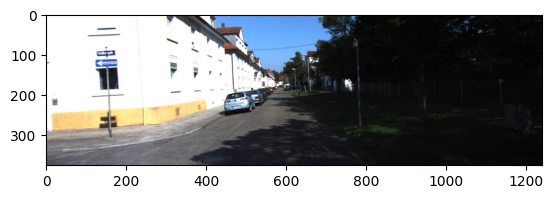

In [36]:
left_img, right_img, gt = val_subset.__getitem__(random.randint(0, len(val_subset)-1))

left_img = left_img.unsqueeze(0)
right_img = right_img.unsqueeze(0)
gt = gt.unsqueeze(0)
plot_tensor2d(left_img[0].cpu())

In [37]:
left_img = left_img.to(device)
right_img = right_img.to(device)
gt = gt.to(device)

model.eval()
with torch.no_grad():
    pred_1h = model(left_img, right_img)

pred = torch.argmax(pred_1h, dim=1)



In [38]:
visualize_labeled_array3d((pred.view(64, 64, 8).float()).detach().cpu().numpy(), size = 2, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [39]:
visualize_labeled_array3d((gt.view(64, 64, 8).float()).detach().cpu().numpy(), size = 2, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…